# LangGraph Agent
## With Tools

## Library Imports

In [41]:
# Way to communicate with agent
from langchain_core.messages import HumanMessage

# Interact with Anthropic model
from langchain_anthropic import ChatAnthropic

# Enable different parts of LangGraph Framework
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
import logging

# Formatting the message returned by the agent
from IPython.display import Image, Markdown, display

# Display visual graphs
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# import toolkit that we created
from swc_toolkit import SportsWorldCentralToolkit

# LangChain tool functionality
from langchain_core.tools import tool

# LangChain support for toolkits
from langgraph.prebuilt import ToolNode
from typing import Literal

In [42]:
import os
from dotenv import load_dotenv, find_dotenv

# dotenv_path = join(dirname(__file__), '.env')
load_dotenv(find_dotenv())

# You already doing it, you already loading your .env then you giving it to another env
# This part not needed
# Langchain
# os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING_V2')
# os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
# os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
# AvalAI
# os.environ['ANTHROPIC_API_BASE'] = os.getenv('ANTHROPIC_API_BASE')
# os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")

In [43]:
# print(os.environ['ANTHROPIC_API_BASE'])
# print(os.environ['ANTHROPIC_API_KEY'])

In [44]:
import sys

if "ANTHROPIC_API_BASE" not in os.environ:
    logging.critical("ANTHROPIC_API_BASE environment variable is not set")
    sys.exit(1)

if "ANTHROPIC_API_KEY" not in os.environ:
    logging.critical("ANTHROPIC_API_KEY environment variable is not set")
    sys.exit(1)

## Configure logging

In [45]:
# remove any existing logging handler
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set logging level to INFO
logging.basicConfig(
    filename="langgraph_notebook.log",
    level=logging.INFO,
)

## Create toolkit

In [46]:
# reference the toolkit that we created
swc_toolkit = SportsWorldCentralToolkit()
# create an instance of your toolkit class + retrieve all of the tools -> put those into tools object
tools = swc_toolkit.get_tools()

## Configure Agent and Model

In [47]:
!curl https://api.avalai.ir/public/models | grep "claude"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0      "id": "anthropic.claude-haiku-4-5-20251001-v1:0",
      "id": "anthropic.claude-3-5-haiku-20241022-v1:0",
      "id": "anthropic.claude-3-haiku-20240307-v1:0",
      "id": "anthropic.claude-sonnet-4-5-20250929-v1:0",
      "id": "anthropic.claude-opus-4-1-20250805-v1:0",
      "id": "anthropic.claude-opus-4-20250514-v1:0",
      "id": "anthropic.claude-sonnet-4-20250514-v1:0",
      "id": "anthropic.claude-3-7-sonnet-20250219-v1:0",
      "id": "anthropic.claude-3-5-sonnet-20241022-v2:0",
      "id": "anthropic.claude-3-5-sonnet-20240620-v1:0",
      "id": "anthropic.claude-3-sonnet-20240229-v1:0",
100  130k  100  130k    0     0   152k      0 --:--:-- --:--:-- --:--:--  152k


In [54]:
tool_node = ToolNode(tools)
# Initialize Anthropic model, temperature sets how creative a model are, lesser the temperature =  less creative
# Binding tools to model: making the model aware of the tools it has access to
model = ChatAnthropic(
    api_key=anthropic_api_key,
    base_url="https://api.avalai.ir",
    model="anthropic.claude-haiku-4-5-20251001-v1:0",
    temperature=0,
    # bind_tools enable the model to use the toolkit you created
).bind_tools(tools)

# to see the Secretstr value
# val = model.anthropic_api_key.get_secret_value()
# print(val)

# conditional edge+ workflow that decides how to proceed based on the results.
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # if model suggest tool call, this returns the literal "tools"
    if last_message.tool_calls:
        return "tools"
    return END


# Send message to model with state object
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


# define the task that is available to agent
workflow = StateGraph(MessagesState)
# the agent node will use call_model function above
workflow.add_node("agent", call_model)
# graph node to perform tool call using toolkit
workflow.add_node("tools", tool_node)
# defines the start of the graph -> directly call the agent node
workflow.add_edge(START, "agent")
# add conditional edge 0> use should_continue function
workflow.add_conditional_edges("agent", should_continue,)
workflow.add_edge("tools", "agent")
# compile the graph into runnable LangChain object -> app
# https://python.langchain.com/v0.2/docs/concepts/#runnable-interface
checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

## Visualize the Graph
Help you see the nodes and edges that is created in this code

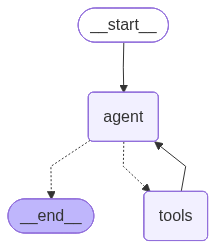

In [55]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Chat with the LangGraph Agent
`app.invoke()` + `messages` object = conversation with agent <br>
`invoke()` contain a `config` object + `thread_id` value <br>
`tread_id` enable the model to remember the previous messages within conversation

In [ ]:
# final_state contains a list of messages between the model and the human
final_state = app.invoke(
    # send messages object and adds a question as a HumanMessage
    {"messages": [HumanMessage(content="What teams did Joe Montana play for?")]},
    # pass thread_id so the agent will remember the previous messages in the same conversation
    config={"configurable": {"thread_id": 99}},
)

In [61]:
# The most recent message will get shown in the -1
# remember models are nondeterministic = interactions may be slightly different
display(Markdown(final_state["messages"][-1].content))

I don't have any information about a fantasy football platform called "SportsWorldCentral" or its leagues. This could be a smaller or regional platform that isn't widely documented, or it may be a fictional platform.

If you're looking for information about this platform, I'd recommend:
- Visiting their official website directly
- Checking their help or FAQ section
- Contacting their customer support

Is there something specific about fantasy football leagues or platforms I can help you with?

In [62]:
final_state = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="What are the leagues in the SportsWorldCentral fantasy football platform?"
            )
        ]
    },
    config={"configurable": {"thread_id": 99}},
)
display(Markdown(final_state["messages"][-1].content))

Based on the data I retrieved, here are the leagues in the SportsWorldCentral fantasy football platform:

1. **Pigskin Prodigal Fantasy League** (League ID: 5001)
   - Scoring Type: PPR (Points Per Reception)
   - 12 teams

2. **Recurring Champions League** (League ID: 5002)
   - Scoring Type: Half-PPR
   - 8 teams

3. **AHAHFZZFFFL** (League ID: 5003)
   - Scoring Type: Half-PPR
   - 8 teams

4. **Gridiron Gurus Fantasy League** (League ID: 5004)
   - Scoring Type: PPR
   - 12 teams

5. **Best League Ever** (League ID: 5005)
   - Scoring Type: PPR
   - 12 teams

These leagues contain various fantasy football teams with different scoring formats. Would you like more details about any specific league or its teams?

In [63]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="What are the leagues in the SportsWorldCentral fantasy football platform? Keep the response simple.")]},
    config={"configurable": {'thread_id': 99}}
)
display(Markdown(final_state["messages"][-1].content))

Here are the leagues in SportsWorldCentral:

1. Pigskin Prodigal Fantasy League
2. Recurring Champions League
3. AHAHFZZFFFL
4. Gridiron Gurus Fantasy League
5. Best League Ever